In [1]:
import pandas as pd
import sqlite3
from pathlib import Path
import numpy as np
from scipy.stats import norm, lognorm, poisson, pareto
from scipy.stats.mstats import gmean
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo

def extract_code(input_string):
    return input_string[:3]

def extract_year(input_string):
    return int(input_string.split('/')[-1])

def extract_year_2(input_string):
    return int(str(input_string).split('-')[0])

In [2]:
# 连接到 SQLite 数据库
conn = sqlite3.connect('data/daily.db')

# 获取数据库中的所有表格名称
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# 将每个表格生成 DataFrame
dfs = {}
for table in tables:
    table_name = table[0]
    if table_name in ['Cover_sheet', 'notes', 'pivot']:
        continue
    query = f'SELECT * FROM "{table_name}";'
    df = pd.read_sql_query(query, conn)
    dfs[table_name] = df

# 关闭数据库连接
conn.close()
# guide https://www.gov.uk/government/statistics/fire-statistics-incident-level-datasets/daily-incident-dataset-guidance
daily = dfs


# House data

现在打算用房价去预测

In [3]:


# guide: https://www.gov.uk/government/publications/about-the-uk-house-price-index/about-the-uk-house-price-index#data-tables
house = pd.read_csv('data/UK-HPI-full-file-2023-02.csv')

house['Region_code'] = house['AreaCode'].apply(extract_code)
house['year'] = house['Date'].apply(extract_year)

region_df = house[house['Region_code']=='E12']
region_df = region_df[region_df['year'] >= 2011]
region_df = region_df[region_df['year'] <= 2021]

In [4]:
region = {
    'South West': ['Cornwall', 'Devon & Somerset', 'Avon', 'Gloucestershire', 'Dorset & Wiltshire', 'Isles of Scilly'],
    'South East': ['Oxfordshire', 'Buckinghamshire & Milton Keynes', 'Hampshire and Isle of Wight', 'West Sussex', 'East Sussex', 'Kent', 'Surrey', 'Royal Berkshire'],
    'London': ['London Fire and Emergency Planning Authority'],
    'East of England': ['Hertfordshire', 'Bedfordshire', 'Cambridgeshire', 'Norfolk', 'Suffolk', 'Essex'],
    'East Midlands': ['Derbyshire', 'Leicestershire', 'Northamptonshire', 'Lincolnshire', 'Nottinghamshire and City of Nottingham'],
    'Yorkshire and The Humber': ['North Yorkshire', 'West Yorkshire', 'South Yorkshire', 'Humberside'],
    'North West': ['Cumbria', 'Lancashire', 'Cheshire', 'Merseyside', 'Greater Manchester'],
    'West Midlands': ['Shropshire', 'Hereford & Worcester', 'Warwickshire', 'West Midlands', 'Stoke-on-Trent and Staffordshire'],
    'North East': ['Cleveland', 'County Durham and Darlington', 'Northumberland', 'Tyne and Wear']
}

fire2code = {'Avon': 'E31000001', 'Bedfordshire': 'E31000002', 'Buckinghamshire & Milton Keynes': 'E31000004', 'Cambridgeshire': 'E31000005', 'Cheshire': 'E31000006', 'Cleveland': 'E31000007', 'Cornwall': 'E31000008', 'County Durham and Darlington': 'E31000013', 'Cumbria': 'E31000009', 'Derbyshire': 'E31000010', 'Devon & Somerset': 'E31000011', 'Dorset & Wiltshire': 'E31000047', 'East Sussex': 'E31000014', 'Essex': 'E31000015', 'Gloucestershire': 'E31000016', 'Greater Manchester': 'E31000040', 'Hampshire and Isle of Wight': 'E31000048', 'Hereford & Worcester': 'E31000018', 'Hertfordshire': 'E31000019', 'Humberside': 'E31000020', 'Isles of Scilly': 'E31000039', 'Kent': 'E31000022', 'Lancashire': 'E31000023',
    'Leicestershire': 'E31000024', 'Lincolnshire': 'E31000025', 'London Fire and Emergency Planning Authority': 'E31000046', 'Merseyside': 'E31000041', 'Norfolk': 'E31000026', 'North Yorkshire': 'E31000027', 'Northamptonshire': 'E31000028', 'Northumberland': 'E31000029', 'Nottinghamshire and City of Nottingham': 'E31000030', 'Oxfordshire': 'E31000031', 'Royal Berkshire': 'E31000003', 'Shropshire': 'E31000032', 'South Yorkshire': 'E31000042', 'Stoke-on-Trent and Staffordshire': 'E31000033', 'Suffolk': 'E31000034', 'Surrey': 'E31000035', 'Tyne and Wear': 'E31000043', 'Warwickshire': 'E31000036', 'West Midlands': 'E31000044', 'West Sussex': 'E31000037', 'West Yorkshire': 'E31000045'}

region2code = {'East Midlands': 'E12000004', 'East of England': 'E12000006', 'London': 'E12000007', 'North East': 'E12000001', 'North West': 'E12000002', 'South East': 'E12000008', 'South West': 'E12000009', 'West Midlands': 'E12000005', 'Yorkshire and The Humber': 'E12000003'}

all_region_code = list(region2code.values())

code = {}

for key, value in region.items():
    code[region2code[key]] = [fire2code[x] for x in value]

# print(code)

reversed_code = {value: key for key, values in code.items() for value in values}
reversed_region2code = {values: key for key, values in region2code.items()}

print(reversed_code)

all_region = []

# for key, value in code.items():
#     all_region.extend(value)
# print(all_region)

region_year_counts = pd.Series()
region_year_dwe_counts = pd.Series()
condition = ~df['FRIS_INCIDENT_TYPE'].isin(['Non-fire incidents', 'Malicious', 'Non-fire false alarms', 'Good intent', 'Due to apparatus'])

for sheet_name, sheet_data in daily.items():
    print(f"Sheet Name: {sheet_name}")
    sheet_data['AREA'] = sheet_data['E_CODE_TERRITORY'].map(reversed_code)

    # Find out each year in each region the percentage about dwelling fires
    sheet_data_only_dwe = sheet_data[sheet_data['FRIS_INCIDENT_TYPE'] == 'Dwellings']

    region_year_dwe_count = sheet_data_only_dwe.groupby(['CALENDAR_YEAR', 'AREA']).size()
    region_year_dwe_counts = pd.concat([region_year_dwe_counts, region_year_dwe_count])
    region_year_count = sheet_data.groupby(['CALENDAR_YEAR', 'AREA']).size()
    region_year_counts = pd.concat([region_year_counts, region_year_count])
print(region.keys())
# 转换为 MultiIndex
region_year_counts.index = pd.MultiIndex.from_tuples(region_year_counts.index)
region_year_dwe_counts.index = pd.MultiIndex.from_tuples(region_year_dwe_counts.index)
print(region_year_counts)

{'E31000008': 'E12000009', 'E31000011': 'E12000009', 'E31000001': 'E12000009', 'E31000016': 'E12000009', 'E31000047': 'E12000009', 'E31000039': 'E12000009', 'E31000031': 'E12000008', 'E31000004': 'E12000008', 'E31000048': 'E12000008', 'E31000037': 'E12000008', 'E31000014': 'E12000008', 'E31000022': 'E12000008', 'E31000035': 'E12000008', 'E31000003': 'E12000008', 'E31000046': 'E12000007', 'E31000019': 'E12000006', 'E31000002': 'E12000006', 'E31000005': 'E12000006', 'E31000026': 'E12000006', 'E31000034': 'E12000006', 'E31000015': 'E12000006', 'E31000010': 'E12000004', 'E31000024': 'E12000004', 'E31000028': 'E12000004', 'E31000025': 'E12000004', 'E31000030': 'E12000004', 'E31000027': 'E12000003', 'E31000045': 'E12000003', 'E31000042': 'E12000003', 'E31000020': 'E12000003', 'E31000009': 'E12000002', 'E31000023': 'E12000002', 'E31000006': 'E12000002', 'E31000041': 'E12000002', 'E31000040': 'E12000002', 'E31000032': 'E12000005', 'E31000018': 'E12000005', 'E31000036': 'E12000005', 'E31000044'

/tmp/ipykernel_9611/2462539721.py:38: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_9611/2462539721.py:39: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Sheet Name: 202021
Sheet Name: 201920
Sheet Name: 201819
Sheet Name: 201718
Sheet Name: 201617
Sheet Name: 201516
Sheet Name: 201415
Sheet Name: 201314
Sheet Name: 201213
Sheet Name: 201112
Sheet Name: 201011
dict_keys(['South West', 'South East', 'London', 'East of England', 'East Midlands', 'Yorkshire and The Humber', 'North West', 'West Midlands', 'North East'])
2021  E12000001    29955
      E12000002    62190
      E12000003    46159
      E12000004    29935
      E12000005    37869
                   ...  
2011  E12000005    13911
      E12000006    12285
      E12000007    26388
      E12000008    18207
      E12000009    12779
Length: 216, dtype: int64


In [5]:




print(len(all_region_code))
color = ['red', 'green', 'blue', 'yellow', 'pink', 'black', 'orange', 'cyan', 'purple']
color_map ={}
for i in range(len(color)):
    color_map[all_region_code[i]]=color[i]
data = {}
year_list = []
region_list = []
value_list = []
# 获取数据
v = 0
all_year = range(2011, 2023)
# print(all_year)
# for r in all_region_code:
#     for y in all_year:
#         value = region_year_counts.loc[(y, r)]
#         v = int(value) if isinstance(value, int) else sum(value)
#         # data[(y, r)] = v
#         year_list.append(y)
#         region_list.append(r)
#         value_list.append(v)
#         # print(len(value))

# # 使用Plotly创建散点图
# fig = go.Figure(data=go.Scatter3d(
#     x=year_list,
#     y=region_list,
#     z=value_list,
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=[color_map[r] for r in region_list],
#         colorscale='Viridis',
#         opacity=0.8
#     )
# ))

# # 设置布局
# fig.update_layout(scene=dict(
#     xaxis=dict(title='Year'),
#     yaxis=dict(title='Region'),
#     zaxis=dict(title='Value')
# ))

# # 显示图形
# pyo.plot(fig, filename='plot.html')

9


# 房价与索赔金额的关系

现在暂时认为每个地区都是常数c

In [6]:
def search_region_and_year_price(region, year):
    year = int(year)
    assert isinstance(region, str) and isinstance(year, int), "region must be str / year must be int"
    return region_df[(region_df['AreaCode'] == region) & (region_df['year'] == year)]['AveragePrice'].mean()
def search_region_and_year_fire_times(region, year):
    year = int(year)
    assert isinstance(region, str) and isinstance(year, int), "region must be str / year must be int"
    value = region_year_counts.loc[(year, region)]
    v = int(value) if isinstance(value, int) else sum(value)
    return v

def search_region_and_year_dwel_fire_times(region, year):
    year = int(year)
    assert isinstance(region, str) and isinstance(year, int), "region must be str / year must be int"
    value = region_year_dwe_counts.loc[(year, region)]
    v = int(value) if isinstance(value, int) else sum(value)
    return v

{'E12000004': 'East Midlands', 'E12000006': 'East of England', 'E12000007': 'London', 'E12000001': 'North East', 'E12000002': 'North West', 'E12000008': 'South East', 'E12000009': 'South West', 'E12000005': 'West Midlands', 'E12000003': 'Yorkshire and The Humber'}
East Midlands
East of England
London
North East
North West
South East
South West
West Midlands
Yorkshire and The Humber
9


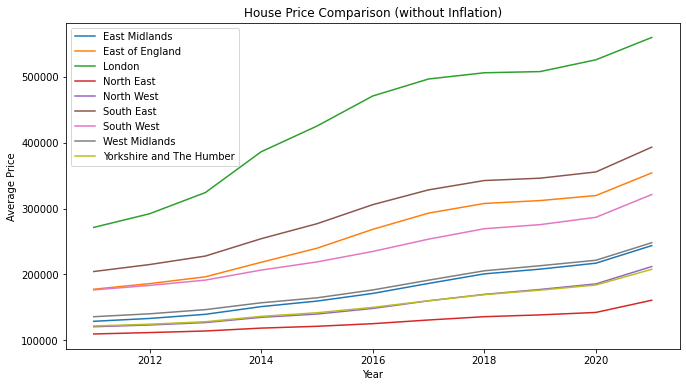

In [7]:
# 画图
CPI = [
93.4,
96.1,
98.5,
100.0,
100.0,
100.7,
103.4,
105.9,
107.8,
108.7,
111.6,
121.7
]

time = all_year  # 时间点
region_data = []
labels = []
print(reversed_region2code)
fig = plt.figure(figsize=(11, 6))
for r in all_region_code:
    region_temp = []
    labels.append(reversed_region2code[r])
    print(reversed_region2code[r])
    for y in all_year:
        region_temp.append(search_region_and_year_price(r, y) * CPI[y-2011]/100)
    plt.plot(all_year, region_temp)
    region_data.append(region_temp)
# 绘制堆积面积图
print(len(region_data))
# for i in region_data:
#     print(len(i))
# plt.stackplot(time, region_data, labels=labels, baseline='zero')

# 设置标题和轴标签
plt.title('House Price Comparison (without Inflation)')
plt.xlabel('Year')
plt.ylabel('Average Price')

# 添加图例
plt.legend(labels, loc='upper left')
plt.savefig('House Price Comparison (without Inflation).jpg', dpi=300)
# 显示图表
plt.show()

# 房价分布预测

满足对数正态分布

一些ref：
- https://ideas.repec.org/p/eti/dpaper/11019.html
- https://www.gov.uk/government/publications/about-the-uk-house-price-index/quality-and-methodology

In [8]:
map_dict = {
'KENT': 'South East',
'GLOUCESTERSHIRE': 'South West',
'READING': 'South East',
'SURREY': 'South East',
'CITY OF DERBY': 'East Midlands',
'NORTH LINCOLNSHIRE': 'Yorkshire and The Humber',
'WOKINGHAM': 'South East',
'CITY OF NOTTINGHAM': 'East Midlands',
'BOURNEMOUTH, CHRISTCHURCH AND POOLE': 'South West',
'WILTSHIRE': 'South West',
'ESSEX': 'East of England',
'WEST NORTHAMPTONSHIRE': 'East Midlands',
'SWANSEA': 'Wales',
'HALTON': 'North West',
'CAMBRIDGESHIRE': 'East of England',
'SOUTH GLOUCESTERSHIRE': 'South West',
'STOCKTON-ON-TEES': 'North East',
'EAST RIDING OF YORKSHIRE': 'Yorkshire and The Humber',
'DENBIGHSHIRE': 'Wales',
'SUFFOLK': 'East of England',
'GREATER LONDON': 'London',
'HARTLEPOOL': 'North East',
'CHESHIRE EAST': 'North West',
'TORFAEN': 'Wales',
'MERSEYSIDE': 'North West',
'CHESHIRE': 'North West',
'NORTHAMPTONSHIRE': 'East Midlands',
'COUNTY DURHAM': 'North East',
'BRACKNELL FOREST': 'South East',
'WEST YORKSHIRE': 'Yorkshire and The Humber',
'ISLES OF SCILLY': 'South West',
'GREATER MANCHESTER': 'North West',
'MERTHYR TYDFIL': 'Wales',
'BUCKINGHAMSHIRE': 'South East',
'NORTH EAST LINCOLNSHIRE': 'Yorkshire and The Humber',
'RHONDDA CYNON TAFF': 'Wales',
'WARWICKSHIRE': 'West Midlands',
'BOURNEMOUTH': 'South West',
'BATH AND NORTH EAST SOMERSET': 'South West',
'GWYNEDD': 'Wales',
'MEDWAY': 'South East',
'STAFFORDSHIRE': 'West Midlands',
'PEMBROKESHIRE': 'Wales',
'BLACKBURN WITH DARWEN': 'North West',
'OXFORDSHIRE': 'South East',
'WINDSOR AND MAIDENHEAD': 'South East',
'DEVON': 'South West',
'SOMERSET': 'South West',
'BLAENAU GWENT': 'Wales',
'WREKIN': 'West Midlands',
'BEDFORD': 'East of England',
'CENTRAL BEDFORDSHIRE': 'East of England',
'NORTHUMBERLAND': 'North East',
'ISLE OF ANGLESEY': 'Wales',
'LANCASHIRE': 'North West',
'CITY OF KINGSTON UPON HULL': 'Yorkshire and The Humber',
'TORBAY': 'South West',
'EAST SUSSEX': 'South East',
'MONMOUTHSHIRE': 'Wales',
'CUMBRIA': 'North West',
'NEWPORT': 'Wales',
'SOUTHAMPTON': 'South East',
'HEREFORDSHIRE': 'West Midlands',
'NORFOLK': 'East of England',
'SHROPSHIRE': 'West Midlands',
'SOUTHEND-ON-SEA': 'East of England',
'TYNE AND WEAR': 'North East',
'BLACKPOOL': 'North West',
'SLOUGH': 'South East',
'CAERPHILLY': 'Wales',
'NORTH SOMERSET': 'South West',
'WEST BERKSHIRE': 'South East',
'DARLINGTON': 'North East',
'THURROCK': 'East of England',
'LUTON': 'East of England',
'WEST SUSSEX': 'South East',
'DERBYSHIRE': 'East Midlands',
'MILTON KEYNES': 'South East',
'STOKE-ON-TRENT': 'West Midlands',
'NEATH PORT TALBOT': 'Wales',
'BRIGHTON AND HOVE': 'South East',
'CITY OF PETERBOROUGH': 'East of England',
'CITY OF PLYMOUTH': 'South West',
'WARRINGTON': 'North West',
'MIDDLESBROUGH': 'North East',
'CEREDIGION': 'Wales',
'DORSET': 'South West',
'CORNWALL': 'South West',
'THE VALE OF GLAMORGAN': 'Wales',
'FLINTSHIRE': 'Wales',
'POOLE': 'South West',
'LEICESTERSHIRE': 'East Midlands',
'CHESHIRE WEST AND CHESTER': 'North West',
'SOUTH YORKSHIRE': 'Yorkshire and The Humber',
'NORTH NORTHAMPTONSHIRE': 'East Midlands',
'LINCOLNSHIRE': 'East Midlands',
'RUTLAND': 'East Midlands',
'HAMPSHIRE': 'South East',
'CARMARTHENSHIRE': 'Wales',
'HERTFORDSHIRE': 'East of England',
'ISLE OF WIGHT': 'South East',
'PORTSMOUTH': 'South East',
'BRIDGEND': 'Wales',
'WREXHAM': 'Wales',
'NORTH YORKSHIRE': 'Yorkshire and The Humber',
'LEICESTER': 'East Midlands',
'CITY OF BRISTOL': 'South West',
'WEST MIDLANDS': 'West Midlands',
'CARDIFF': 'Wales',
'YORK': 'Yorkshire and The Humber',
'WORCESTERSHIRE': 'West Midlands',
'POWYS': 'Wales',
'CONWY': 'Wales',
'NOTTINGHAMSHIRE': 'East Midlands',
'SWINDON': 'South West',
'REDCAR AND CLEVELAND': 'North East'
}

In [9]:
def process_house_price_csv(file_path):
    data_sheet = pd.read_csv(file_path, header=None)
    data_sheet["AREA"] = data_sheet[13].map(map_dict)
    data_sheet = data_sheet[data_sheet['AREA'] != 'Wales']
    data_sheet["AREA_CODE"] = data_sheet["AREA"].map(region2code)
    data_sheet['YEAR'] = data_sheet[2].apply(extract_year_2)
    year = data_sheet["YEAR"].unique()
    
    assert len(year) == 1
    year = year[0]
    
    ret_dict = {}
    # print mean value of column 1
    print(data_sheet[1].mean())
    for region_code in data_sheet["AREA_CODE"].unique():
        ret_dict[(region_code, year)] = list(data_sheet[data_sheet["AREA_CODE"] == region_code][1])
    
    return ret_dict

house_price_dir = Path(r'house_price/')

house_pirce_dict = {}
for price_file in house_price_dir.iterdir():
    print(price_file)
    ret_dict = process_house_price_csv(price_file)
    house_pirce_dict.update(ret_dict)

house_price/pp-2020.csv
386224.3103939607
house_price/pp-2018.csv
359678.0701248211
house_price/pp-2017.csv
354604.6993318728
house_price/pp-2016.csv
320304.9422105041
house_price/pp-2012.csv
242492.56265426343
house_price/pp-2013.csv
261772.82969535075
house_price/pp-2021.csv
391030.45857868594
house_price/pp-2022.csv
404752.3985122104
house_price/pp-2014.csv
285345.11021422053
house_price/pp-2011.csv
236724.34116282832
house_price/pp-2015.csv
303202.8657763861
house_price/pp-2019.csv
361367.9119191097


In [10]:
def search_region_and_year_house_prices(region, year):
    year = int(year)
    assert isinstance(region, str) and isinstance(year, int), "region must be str / year must be int"
    return house_pirce_dict[(region, year)]



def get_region_and_year_house_price_distribution(r, y):
        house_prices = search_region_and_year_house_prices(r, y)
        log_prices = np.log(house_prices)
        mu, sigma = np.mean(log_prices), np.std(log_prices)
        return norm(mu, sigma)

# x = np.linspace(0, 14, 1000)

# pdf = get_region_and_year_house_price_distribution(all_region_code[0], 2015).pdf(x)

# # # 绘制泊松分布的PDF
# plt.plot(np.exp(x), pdf, 'r', label='Poisson PDF')

# plt.xlabel('Value')
# plt.ylabel('Probability')
# plt.legend()
# plt.show()
for r in all_region_code:
    for y in all_year:
        print(r, y, gmean(search_region_and_year_house_prices(r, y))-search_region_and_year_price(r, y))
        break

E12000004 2011 2321.778997860005
E12000006 2011 8349.213887466321
E12000007 2011 34658.809659003746
E12000001 2011 -1571.509652029752
E12000002 2011 155.82757677364862
E12000008 2011 14488.366855783359
E12000009 2011 5814.855726070091
E12000005 2011 2160.73527149405
E12000003 2011 1804.476250757929


In [11]:
print(list(all_year))
print(reversed_region2code)

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
{'E12000004': 'East Midlands', 'E12000006': 'East of England', 'E12000007': 'London', 'E12000001': 'North East', 'E12000002': 'North West', 'E12000008': 'South East', 'E12000009': 'South West', 'E12000005': 'West Midlands', 'E12000003': 'Yorkshire and The Humber'}


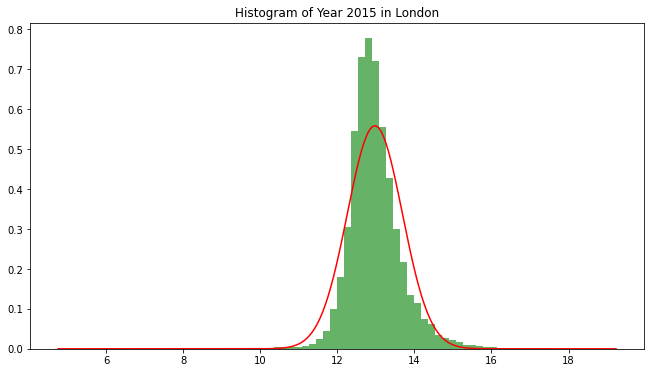

In [12]:
#画图
# fit_distribution = get_region_and_year_house_price_distribution(all_region_code[0], 2015)

# # 绘制QQ图
# stats.probplot(search_region_and_year_house_prices(all_region_code[0], 2015), dist=fit_distribution, plot=plt)

# # 设置标题和轴标签
# plt.title("QQ Plot")
# plt.xlabel("Theoretical Quantiles")
# plt.ylabel("Ordered Values")

data = search_region_and_year_house_prices('E12000007', 2015)
logdata = np.log(data)


import numpy as np
from scipy.stats import pareto, norm
import matplotlib.pyplot as plt
import statsmodels.api as sm

def generate_mixture_model(data, p_norm=1.0, p_pareto=0.0, loc_norm=0, scale_norm=1, b_pareto=2.62):
    """
    Generate a mixture of normal and pareto distributions, based on the input parameters.
    """
    # Ensure the probabilities sum to 1
    assert np.isclose(p_norm + p_pareto, 1), "Probabilities must sum to 1"

    # Determine the number of samples
    n_samples = len(data)

    # Generate the mixed distribution
    mixed_data = []
    for _ in range(n_samples):
        if np.random.random() < p_norm:
            mixed_data.append(norm.rvs(loc=loc_norm, scale=scale_norm))
        else:
            mixed_data.append(pareto.rvs(b_pareto))

    return mixed_data

def plot_qq(data):
    """
    Plot the QQ plot of the data.
    """
    fig = plt.figure(figsize=(11, 6))
    sm.qqplot(np.array(data), line ='45') 
    plt.title(f"QQ Plot of Year 2015 in {reversed_region2code['E12000007']}")
    plt.savefig(f'qq_2015_{reversed_region2code["E12000007"]}.jpg', dpi=300)
    plt.show()
    
def plot_hist_and_distribution(data):
    fig = plt.figure(figsize=(11, 6))
    plt.hist(data, bins=80, density=True, alpha=0.6, color='g')
    x = np.linspace(min(data), max(data), 1000)
    plt.plot(x, norm.pdf(x, loc=np.mean(data), scale=np.std(data)), 'r')
    plt.title(f"Histogram of Year 2015 in {reversed_region2code['E12000007']}")

    # plt.title(f"QQ Plot of Year 2015 in {reversed_region2code['E12000007']}")
    plt.savefig(f'compare_2015_{reversed_region2code["E12000007"]}.jpg', dpi=300)
    plt.show()

    

# Generate the mixed model and plot the QQ plot
# data = np.random.rand(1000)
mixed_data = generate_mixture_model(data)

plot_hist_and_distribution(logdata)



# 火灾次数分布预测

对于一年内火灾的发生次数，这是一个典型的计数问题。在统计学中，处理这种类型的数据的常用概率分布包括泊松分布和负二项分布。

In [13]:
def get_region_fire_times_distribution(r):
    lambda_ = 0
    for y in all_year:
        lambda_  += search_region_and_year_fire_times(r, y)
    lambda_ = int(lambda_ / len(all_year))
    distri = poisson(lambda_)
    return distri

def get_region_dwel_fire_times_distribution(r):
    lambda_ = 0
    for y in all_year:
        lambda_  += search_region_and_year_dwel_fire_times(r, y)
    lambda_ = int(lambda_ / len(all_year))
    distri = poisson(lambda_)
    return distri

In [14]:
# for r in all_region:
#     search_region_and_year_fire_times()

In [15]:
# fig = plt.figure(figsize=(11, 6))
# text_y = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
# i = 0
# for r in all_region_code:
#     x = np.arange(200, 1300)
#     distri = get_region_dwel_fire_times_distribution(r)
#     plt.axvline(x=distri.args[0], linestyle='--')
#     plt.plot(x, distri.pmf(x), label=reversed_region2code[r])
#     plt.text(((distri.args[0])/(1210-0))-0.135, text_y[i], f'λ = {distri.args[0]}', transform=plt.gca().transAxes, rotation=90, va='center')
#     i += 1
#     # break
    
# plt.legend()
# plt.xlabel('Number of Fires')
# plt.ylabel('PMF')
# plt.ylim(0, 0.026)
# plt.title('Poisson Distribution PMF')
# plt.savefig(f'fire_dwell_times_pmf.jpg', dpi=300)
# plt.show()


In [16]:
# year_list = []
# region_list = []
# year_fire_cliam_list = []
# for r in all_region_code:
#     for y in all_year:
#         year_fire_cliam = year_fire_cliam_df[(y, r)]
#         year_list.append(y)
#         region_list.append(r)
#         year_fire_cliam_list.append(year_fire_cliam)

# # 使用Plotly创建散点图
# fig = go.Figure(data=go.Scatter3d(
#     x=year_list,
#     y=region_list,
#     z=value_list,
#     mode='markers',
#     marker=dict(
#         size=5,
#         color=[color_map[r] for r in region_list],
#         colorscale='Viridis',
#         opacity=0.8
#     )
# ))

# # 设置布局z
# fig.update_layout(scene=dict(
#     xaxis=dict(title='Year'),
#     yaxis=dict(title='Region'),
#     zaxis=dict(title='year_fire_cliam')
# ))

# # 显示图形
# pyo.plot(fig, filename='year_fire_cliam.html')

# 火灾价格分布

就是 p * 房价的分布 * (CPI/100)

使用蒙特卡洛模拟来获取住宅火灾占总火灾的数量

https://chat.openai.com/c/cf69873e-58f8-4222-bc5c-4469e1aea668

In [17]:
def simulate_fire_ratio(poisson_all, poisson_residential, num_simulations=1000000):
    # 计算一次火灾发生在住宅的概率
    p = poisson_residential.args[0] / poisson_all.args[0]

    # 从泊松分布中抽取所有火灾的次数
    all_fires = poisson_all.rvs(num_simulations)

    # 对每年的所有火灾次数进行模拟，确定其中多少是住宅火灾
    residential_fires = np.random.binomial(all_fires, p)

    # 防止0除错误，如果总火灾次数为0，我们将其设置为1（这将使得那些实际上没有火灾的年份的比例为0）
    all_fires[all_fires == 0] = 1

    # 计算比例
    ratios = residential_fires / all_fires

    # 返回比例的数组
    return ratios

  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/tmp/ipykernel_9611/3101157497.py:15: PerformanceWarning:

indexing past lexsort depth may impact performance.



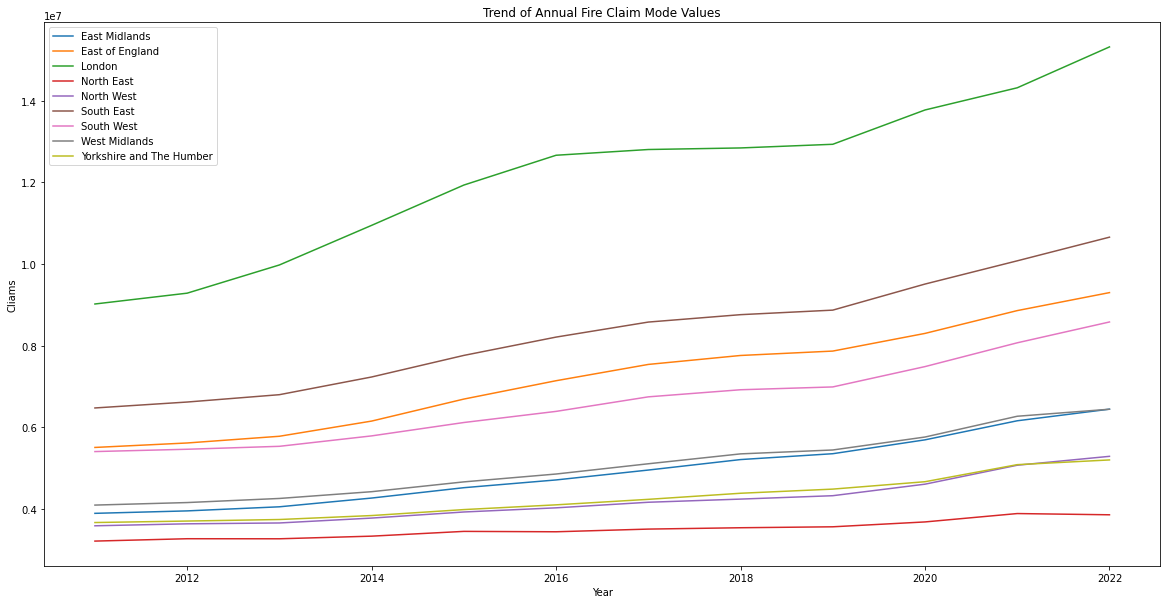

In [26]:
import numpy as np
import matplotlib.pyplot as plt
def simulate_fire_ratio(poisson_all, poisson_residential, num_simulations=1000000):
    # 计算一次火灾发生在住宅的概率
    p = poisson_residential.args[0] / poisson_all.args[0]

    # 从泊松分布中抽取所有火灾的次数
    all_fires = poisson_all.rvs(num_simulations)

    # 对每年的所有火灾次数进行模拟，确定其中多少是住宅火灾
    residential_fires = np.random.binomial(all_fires, p)

    # 防止0除错误，如果总火灾次数为0，我们将其设置为1（这将使得那些实际上没有火灾的年份的比例为0）
    all_fires[all_fires == 0] = 1

    # 计算比例
    ratios = residential_fires / all_fires

    # 返回比例的数组
    return ratios
p = 10000/sum([np.mean(search_region_and_year_house_prices(r, 2015)) for r in all_region_code])*len(all_region_code)
# print(p)

CPI = [
93.4,
96.1,
98.5,
100.0,
100.0,
100.7,
103.4,
105.9,
107.8,
108.7,
111.6,
121.7
]

def calculate_S_pdf(norm_dist, poisson_dist, offset_cliam, offset_fire_times, n_bins=1000):
    # print(offset_fire_times)
    # print(offset_cliam)
    # 生成一些可能的S值
    max_n = int(poisson_dist.ppf(0.999))  # 根据泊松分布的分位数确定可能的最大N值
    N_values = np.arange(0-offset_fire_times, max_n-offset_fire_times)  # N的取值范围
    X_values = np.linspace(norm_dist.ppf(0.001)-offset_cliam, norm_dist.ppf(0.999)-offset_cliam, n_bins)  # X的取值范围
    # 计算每个S值的概率
    N_probs = poisson_dist.pmf(N_values+offset_fire_times)  # N的概率
    X_probs = norm_dist.pdf(X_values+offset_cliam)  # X的概率
    S_probs = np.outer(N_probs, X_probs)  # 所有可能的S值的概率

    # 计算S的概率密度函数
    S_pdf = np.sum(S_probs, axis=0)

    return X_values, S_pdf

fig = plt.figure(figsize=(20, 10))  # 指定宽度为8英寸，高度为6英寸

# 创建lognorm和poisson分布的实例
legend = []
from tqdm.notebook import tqdm
for r in tqdm(all_region_code):
    years = []
    ninty = []
    for y in all_year:
        norm_dist = get_region_and_year_house_price_distribution(r, y)
        poisson_dist = get_region_fire_times_distribution(r)

        # 计算S的概率密度函数
        ratios = simulate_fire_ratio(get_region_fire_times_distribution(r), get_region_dwel_fire_times_distribution(r))
        X_values, S_pdf = calculate_S_pdf(norm_dist, poisson_dist, np.log(p * (CPI[y-2011]/100)), -np.log(np.mean(ratios)))
        temp_p = 0
        temp_x = 0
        for i in range(len(S_pdf)):
            if temp_p < S_pdf[i]:
                temp_p = S_pdf[i]
                continue
            else:
                temp_x = X_values[i-1]
                break
        # print(temp_x)
        
        # 绘制S的概率密度函数
        # plt.plot(np.exp(X_values), S_pdf)
        # plt.title(f'Year: {y}')
        # plt.xlabel('Overall caliam')
        # plt.ylabel('Probability Density')
        years.append(y)
        ninty.append(np.exp(temp_x+np.log((CPI[y-2011]/100))))
    plt.plot(years, ninty)
    legend.append(reversed_region2code[r])
    
plt.title("Trend of Annual Fire Claim Mode Values")
plt.ylabel("Cliams")
# plt.ylim(0.2e6, 2e6)
plt.xlabel("Year")
plt.legend(legend, loc='upper left')
plt.savefig(f'max.jpg', dpi=300)
plt.show()

# 预测

In [31]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
def predict_fire_times(r):
    fire_times = []
    for y in all_year:
        if y in [2022]:
            continue
        v = search_region_and_year_fire_times(r, y)
        fire_times.append(v)

    def create_ARMA_model(data, order=(2, 3, 0)):
        # 将数据转为时间序列
        ts = pd.Series(data)
        ts.index = pd.Index(pd.date_range('2011', periods=len(data), freq='Y'))

        # 建立并拟合ARMA模型
        model = ARIMA(ts, order=order)
        model_fit = model.fit()

        return model_fit

    # print(fire_times)
    model = create_ARMA_model(fire_times)
    # print(model.aic)
    prediction = model.predict(start=len(fire_times), end=len(fire_times)+1)
    return prediction
    
fire_preds = {}
for r in all_region_code:
    # print(f"Refion: {reversed_region2code[r]}")
    pred = predict_fire_times(r)
    fire_preds[reversed_region2code[r]]=int(pred["2023"])
fire_preds

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/tmp/ipykernel_9611/3101157497.py:8: PerformanceWarning:

indexing past lexsort depth may impact performance.

/tmp/ipykernel_9611/31

{'East Midlands': 52744,
 'East of England': 57558,
 'London': 183921,
 'North East': 56030,
 'North West': 106850,
 'South East': 98270,
 'South West': 72537,
 'West Midlands': 50056,
 'Yorkshire and The Humber': 84288}

In [20]:
def create_ARMA_model(data, order=(1, 0, 0)):
    # 将数据转为时间序列
    ts = pd.Series(data)
    ts.index = pd.Index(pd.date_range('2011', periods=len(data), freq='Y'))

    # 建立并拟合ARMA模型
    model = ARIMA(ts, order=order)
    model_fit = model.fit()

    return model_fit

    
model = create_ARMA_model(CPI, (3, 2, 0))
print(CPI)
print(model.summary())
CPI_prediction = model.predict(start=len(CPI), end=len(CPI))
print(CPI_prediction)


[93.4, 96.1, 98.5, 100.0, 100.0, 100.7, 103.4, 105.9, 107.8, 108.7, 111.6, 121.7]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   12
Model:                 ARIMA(3, 2, 0)   Log Likelihood                 -20.993
Date:                Thu, 01 Jun 2023   AIC                             49.985
Time:                        15:31:18   BIC                             51.196
Sample:                    12-31-2011   HQIC                            48.658
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2393      0.568      2.180      0.029       0.125       2.354
ar.L2         -0.9552      1.021     -0.936      

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [29]:
def predict_house_price(r):
    

    def create_ARMA_model(data, order=(2, 3, 0)):
        # 将数据转为时间序列
        ts = pd.Series(data)
        ts.index = pd.Index(pd.date_range('2011', periods=len(data), freq='Y'))

        # 建立并拟合ARMA模型
        model = ARIMA(ts, order=order)
        model_fit = model.fit()

        return model_fit

    # print(fire_times)
    house_price = [] 
    
    for y in all_year:
        house_price.append(np.mean(np.log(search_region_and_year_house_prices(r, y))))
    model = create_ARMA_model(house_price)
    # print(model.aic)
    prediction = model.predict(start=len(house_price), end=len(house_price)+1)
    return prediction
    
house_price_mean_preds = {}
for r in all_region_code:
    # print(f"Refion: {reversed_region2code[r]}")
    pred = predict_house_price(r)
    house_price_mean_preds[reversed_region2code[r]]=float(pred["2023"])
for k,v in house_price_mean_preds.items():
    print("{}: {:.5f}".format(k, v))

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



East Midlands: 12.41746
East of England: 12.77447
London: 13.27747
North East: 11.87081
North West: 12.17349
South East: 12.93920
South West: 12.74061
West Midlands: 12.39147
Yorkshire and The Humber: 12.18806


In [22]:
def predict_house_price_std(r):
    

    def create_ARMA_model(data, order=(2, 3, 0)):
        # 将数据转为时间序列
        ts = pd.Series(data)
        ts.index = pd.Index(pd.date_range('2011', periods=len(data), freq='Y'))

        # 建立并拟合ARMA模型
        model = ARIMA(ts, order=order)
        model_fit = model.fit()

        return model_fit

    # print(fire_times)
    house_price = [] 
    
    for y in all_year:
        house_price.append(np.std(np.log(search_region_and_year_house_prices(r, y))))
    model = create_ARMA_model(house_price)
    # print(model.aic)
    prediction = model.predict(start=len(house_price), end=len(house_price)+1)
    return prediction
    
house_price_std_preds = {}
for r in all_region_code:
    # print(f"Refion: {reversed_region2code[r]}")
    pred = predict_house_price_std(r)
    house_price_std_preds[reversed_region2code[r]]=float(pred["2023"])
for k,v in house_price_std_preds.items():
    print("{}: {:.5f}".format(k, v))

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



East Midlands: 0.57385
East of England: 0.65185
London: 0.76739
North East: 0.64632
North West: 0.58698
South East: 0.67526
South West: 0.64467
West Midlands: 0.59135
Yorkshire and The Humber: 0.64153


/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/jimmy/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



0.03597025028288776


  0%|          | 0/9 [00:00<?, ?it/s]

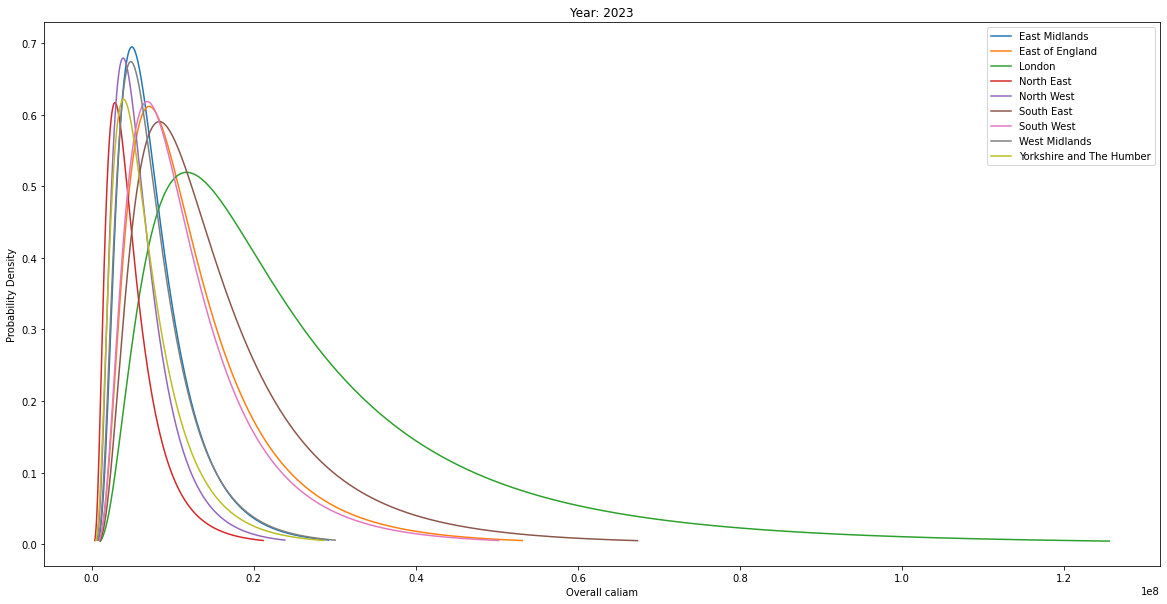

In [27]:
def simulate_fire_ratio(poisson_all, poisson_residential, num_simulations=1000000):
    # 计算一次火灾发生在住宅的概率
    p = poisson_residential.args[0] / poisson_all.args[0]

    # 从泊松分布中抽取所有火灾的次数
    all_fires = poisson_all.rvs(num_simulations)

    # 对每年的所有火灾次数进行模拟，确定其中多少是住宅火灾
    residential_fires = np.random.binomial(all_fires, p)

    # 防止0除错误，如果总火灾次数为0，我们将其设置为1（这将使得那些实际上没有火灾的年份的比例为0）
    all_fires[all_fires == 0] = 1

    # 计算比例
    ratios = residential_fires / all_fires

    # 返回比例的数组
    return ratios
p = 10000/sum([np.mean(search_region_and_year_house_prices(r, 2015)) for r in all_region_code])*len(all_region_code)
print(p)

CPI = [
93.4,
96.1,
98.5,
100.0,
100.0,
100.7,
103.4,
105.9,
107.8,
108.7,
111.6,
121.7
]

def calculate_S_pdf(norm_dist, poisson_dist, offset_cliam=0, offset_fire_times=0, n_bins=1000):
    # print(offset_fire_times)
    # print(offset_cliam)
    # 生成一些可能的S值
    max_n = int(poisson_dist.ppf(0.999))  # 根据泊松分布的分位数确定可能的最大N值
    N_values = np.arange(0-offset_fire_times, max_n-offset_fire_times)  # N的取值范围
    X_values = np.linspace(norm_dist.ppf(0.001)-offset_cliam, norm_dist.ppf(0.999)-offset_cliam, n_bins)  # X的取值范围
    # 计算每个S值的概率
    N_probs = poisson_dist.pmf(N_values+offset_fire_times)  # N的概率
    X_probs = norm_dist.pdf(X_values+offset_cliam)  # X的概率
    S_probs = np.outer(N_probs, X_probs)  # 所有可能的S值的概率

    # 计算S的概率密度函数
    S_pdf = np.sum(S_probs, axis=0)

    return X_values, S_pdf

fig = plt.figure(figsize=(20, 10))  # 指定宽度为8英寸，高度为6英寸

# 创建lognorm和poisson分布的实例
legend = []
from tqdm.notebook import tqdm
for r in tqdm(all_region_code):
    r_name = reversed_region2code[r]
    years = []
    ninty = []
    for y in [2023]:
        norm_dist = norm(house_price_mean_preds[r_name], house_price_std_preds[r_name])
        poisson_dist = poisson(fire_preds[r_name])

        # 计算S的概率密度函数
        X_values, S_pdf = calculate_S_pdf(norm_dist, poisson_dist, float(np.log(p * (CPI_prediction["2023"]/100))))
        # temp_p = 0
        # temp_x = 0
        # for i in range(len(S_pdf)):
        #     if temp_p < S_pdf[i]:
        #         temp_p = S_pdf[i]
        #         continue
        #     else:
        #         temp_x = X_values[i-1]
        #         break
        # print(temp_x)
        
        # 绘制S的概率密度函数
        plt.plot(np.exp(X_values), S_pdf)
        plt.title(f'Year: {y}')
    legend.append(r_name)
    
plt.legend(legend)
plt.xlabel('Overall caliam')
plt.ylabel('Probability Density')
plt.savefig(f'pred.jpg', dpi=300)
plt.show()
    #     years.append(y)
    #     ninty.append(np.exp(temp_x+np.log((CPI[y-2011]/100))))
    # plt.plot(years, ninty)
    # legend.append(reversed_region2code[r])
    
# plt.title("Trend of Annual Fire Claim Mode Values")
# plt.ylabel("Cliams")
# # plt.ylim(0.2e6, 2e6)
# plt.xlabel("Year")
# plt.legend(legend, loc='upper left')
# plt.savefig(f'max.jpg', dpi=300)
# plt.show()

In [40]:
import json
export = {}
export['reversed_region2code'] = reversed_region2code
export['region2code'] = region2code
export['all_year'] = list(all_year)
export['all_region_code'] = all_region_code
export['house_price_mean_preds'] = house_price_mean_preds
export['house_price_std_preds'] = house_price_std_preds
export['fire_preds'] = fire_preds
export['p'] = p
export['CPI_prediction'] = float(CPI_prediction)

for k, v in export.items():
    if isinstance(v, list):
        continue
    else:
        print(v)
    # print(k, type(v))

with open('vis/params.json', 'w') as f:
    json.dump(export, f)

{'E12000004': 'East Midlands', 'E12000006': 'East of England', 'E12000007': 'London', 'E12000001': 'North East', 'E12000002': 'North West', 'E12000008': 'South East', 'E12000009': 'South West', 'E12000005': 'West Midlands', 'E12000003': 'Yorkshire and The Humber'}
{'East Midlands': 'E12000004', 'East of England': 'E12000006', 'London': 'E12000007', 'North East': 'E12000001', 'North West': 'E12000002', 'South East': 'E12000008', 'South West': 'E12000009', 'West Midlands': 'E12000005', 'Yorkshire and The Humber': 'E12000003'}
{'East Midlands': 12.417462349520525, 'East of England': 12.774467708454779, 'London': 13.277467964236967, 'North East': 11.870814869632124, 'North West': 12.17348933793229, 'South East': 12.939202267095798, 'South West': 12.740606814657795, 'West Midlands': 12.391467925182518, 'Yorkshire and The Humber': 12.188056926397252}
{'East Midlands': 0.573849874946497, 'East of England': 0.6518463870646113, 'London': 0.7673893398305673, 'North East': 0.6463234774829804, 'No